<a href="https://colab.research.google.com/github/MyDarapy/Skip-gram-Language-Model-Word2Vec-/blob/main/Skip_gram_Language_Model_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from scipy.spatial.distance import cosine
from tqdm import tqdm

**Load in the Data**

In [3]:
#Remove Stopwords
with open ('stopwords.txt') as file:
  stopwords = file.read().replace('\n', ' ').lower().split()

In [4]:
with open ('Brown (1).txt', encoding= 'utf-8') as f:
  text = f.read().replace('\n', '')
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = text.replace('"', '').replace(',', '').lower().split()

text = [word for word in text if word not in stopwords][:100]

In [5]:
print(text)

['fulton', 'county', 'grand', 'jury', 'said', 'friday', 'investigation', 'atlantas', 'recent', 'primary', 'election', 'produced', 'evidence', 'irregularities', 'took', 'placethe', 'jury', 'said', 'termend', 'presentments', 'city', 'executive', 'committee', 'overall', 'charge', 'election', 'deserves', 'praise', 'thanks', 'city', 'atlanta', 'manner', 'election', 'conductedthe', 'septemberoctober', 'term', 'jury', 'charged', 'fulton', 'superior', 'court', 'judge', 'durwood', 'pye', 'investigate', 'reports', 'possible', 'irregularities', 'hardfought', 'primary', 'won', 'mayornominate', 'ivan', 'allen', 'jronly', 'relative', 'handful', 'reports', 'received', 'jury', 'said', 'considering', 'widespread', 'interest', 'election', 'number', 'voters', 'size', 'citythe', 'jury', 'said', 'find', 'many', 'georgias', 'registration', 'election', 'laws', 'outmoded', 'inadequate', 'often', 'ambiguousit', 'recommended', 'fulton', 'legislators', 'act', 'laws', 'studied', 'revised', 'end', 'modernizing', '

In [6]:
for index, word in enumerate(text):
  print(f"Index {index}: {word}")

Index 0: fulton
Index 1: county
Index 2: grand
Index 3: jury
Index 4: said
Index 5: friday
Index 6: investigation
Index 7: atlantas
Index 8: recent
Index 9: primary
Index 10: election
Index 11: produced
Index 12: evidence
Index 13: irregularities
Index 14: took
Index 15: placethe
Index 16: jury
Index 17: said
Index 18: termend
Index 19: presentments
Index 20: city
Index 21: executive
Index 22: committee
Index 23: overall
Index 24: charge
Index 25: election
Index 26: deserves
Index 27: praise
Index 28: thanks
Index 29: city
Index 30: atlanta
Index 31: manner
Index 32: election
Index 33: conductedthe
Index 34: septemberoctober
Index 35: term
Index 36: jury
Index 37: charged
Index 38: fulton
Index 39: superior
Index 40: court
Index 41: judge
Index 42: durwood
Index 43: pye
Index 44: investigate
Index 45: reports
Index 46: possible
Index 47: irregularities
Index 48: hardfought
Index 49: primary
Index 50: won
Index 51: mayornominate
Index 52: ivan
Index 53: allen
Index 54: jronly
Index 55: 

**Pre-processing**

In [7]:
#Create Negative Sampling
CONTEXT_WINDOW_SIZE = 3
NEGATIVE_SAMPLES_K = 3

data = []
#iterate over all the items in the list (Picking out all the context words which is everything)
for idx, center_word in enumerate(text[CONTEXT_WINDOW_SIZE-1:-CONTEXT_WINDOW_SIZE]):

  #iterate over the context_words
  context_words = [context_word for context_word in text[idx:idx+2*CONTEXT_WINDOW_SIZE-1] if context_word != center_word]
  for context_word in context_words:

    #Randomly select words not in the current example/window as negative examples
    data.append([center_word, context_word, 1])
    negative_samples = np.random.choice([w for w in text[CONTEXT_WINDOW_SIZE-1:-CONTEXT_WINDOW_SIZE] if w != center_word  and w not in context_words], NEGATIVE_SAMPLES_K)

    for negative_sample in negative_samples:
      data.append([center_word, negative_sample, 0])


In [8]:
df = pd.DataFrame(columns= ['center_word', 'context_word', 'label'], data=data)
words = np.intersect1d(df.context_word, df.center_word)
df = df[(df.center_word.isin(words)) & (df.context_word.isin(words))].reset_index(drop = True)

In [9]:
df[30:50]

,center_word,context_word,label
30,said,grand,1
31,said,commented,0
32,said,manner,0
33,said,conductedthe,0
34,said,jury,1
35,said,produced,0
36,said,election,0
37,said,pye,0
38,said,friday,1
39,said,atlantas,0


## **Our Skip Gram Algorithm Functions**



In [10]:
def sigmod_function (v, scale = 1):
  thau = 1/(1+ np.exp(v*scale))
  return thau

In [11]:
def update_embeddings(df, main_embeddings, context_embeddings, learning_rate, debug= False):

  #Find the difference betwwen the main and context embeddings
  main_embeddings_center = main_embeddings.loc[df.center_word].values
  context_embeddings_context = context_embeddings.loc[df.context_word].values
  differences = context_embeddings_context-main_embeddings_center


  #Find the scores and errors
  dot_product = np.sum(main_embeddings_center*context_embeddings_context, axis =1)
  scores = sigmod_function(dot_product)
  errors = (df.label-scores).values.reshape(-1,1)

  if debug:
    plot_words(debug)

  #Make updates accordingly
  updates = differences*errors*learning_rate
  updates_df = pd.DataFrame(data = updates)
  updates_df['center_word'] = df.center_word
  updates_df['context_word'] = df.context_word
  updates_df_center = updates_df.groupby('center_word').sum()
  updates_df_context = updates_df.groupby('context_word').sum()

  #apply updates
  main_embeddings += updates_df_center.loc[main_embeddings.index]
  context_embeddings -= updates_df_context.loc[context_embeddings.index]

  #normalize the embeddings
  main_embeddings = normalize_data(main_embeddings)
  context_embeddings =normalize_data(context_embeddings)


  return (main_embeddings, context_embeddings)


In [12]:
def normalize_data(data):
    row_norms = np.sqrt((data.values**2).sum(axis=1)).reshape(-1,1)
    return data.divide(row_norms, axis='index')

In [13]:
def plot_words(debug):
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    lim_main_first = main_embeddings.loc[[debug[0]]]
    lim_main_second = main_embeddings.loc[[debug[1]]]
    p1 = plt.scatter(lim_main_first[0], lim_main_first[1], color='r')
    plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_first.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_main_second[0], lim_main_second[1], color='r')
    plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_second.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(main_embeddings.loc[debug[0]], main_embeddings.loc[debug[1]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)

    t = np.arange(0, 3.14*2+0.1, 0.1)
    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')

    ###################################

    plt.subplot(1,2,2)
    lim_main = main_embeddings.loc[[debug[0]]]
    lim_context = context_embeddings.loc[[debug[1]]]
    p1 = plt.scatter(lim_main[0], lim_main[1], color='r')
    plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_context[0], lim_context[1], color='b')
    plt.arrow(0,0,float(lim_context[0]), float(lim_context[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_context.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(main_embeddings.loc[debug[0]], context_embeddings.loc[debug[1]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)

    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')

    plt.show()

## **Run Word2Vec**

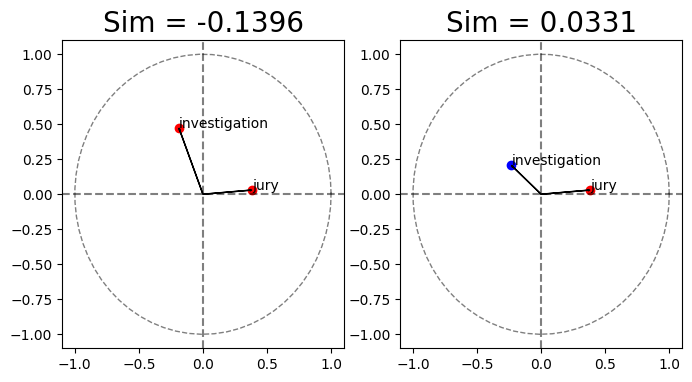

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


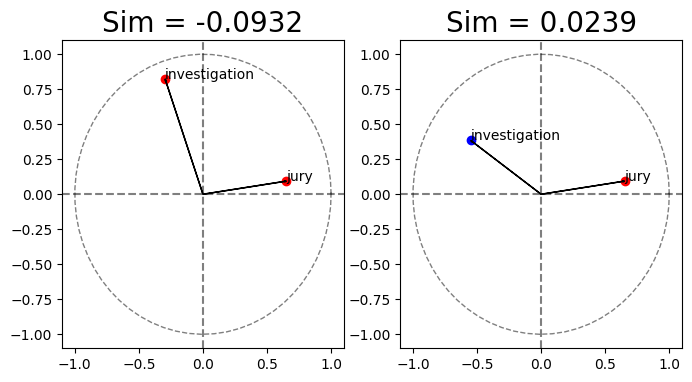

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


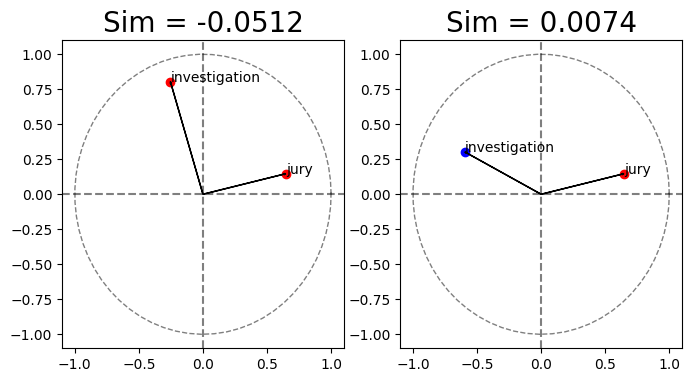

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


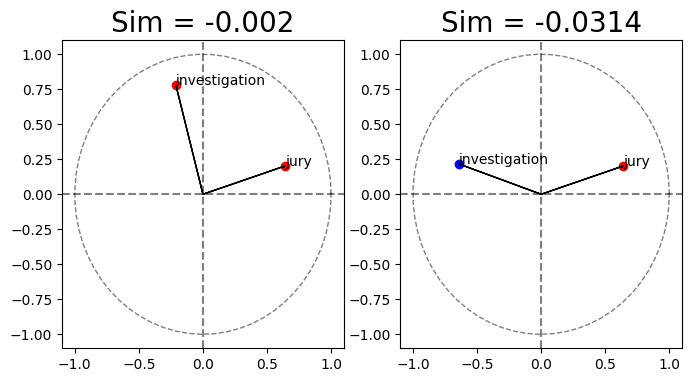

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


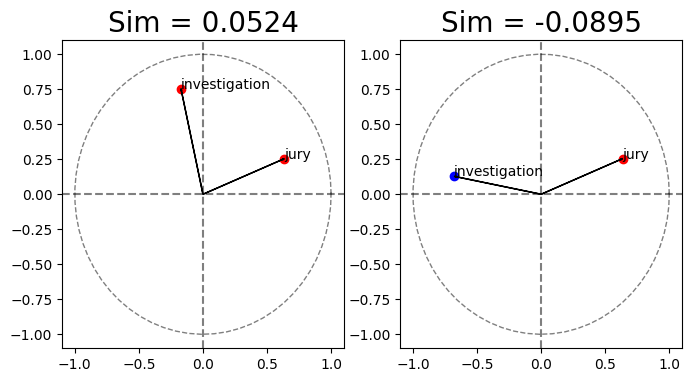

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


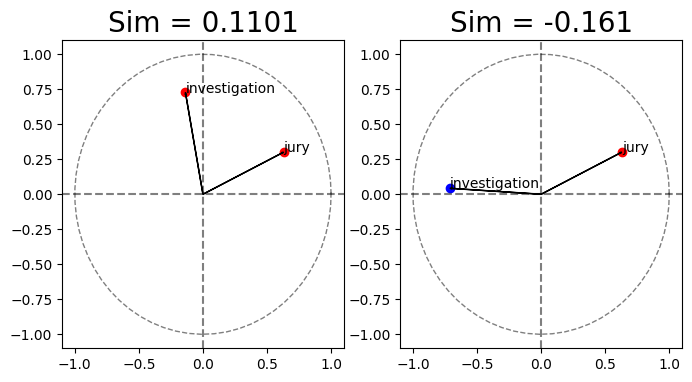

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


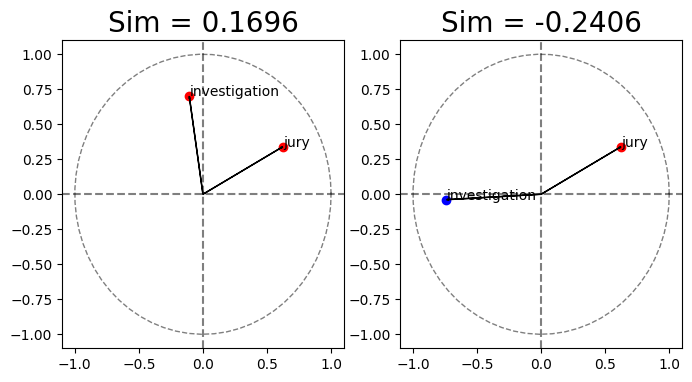

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


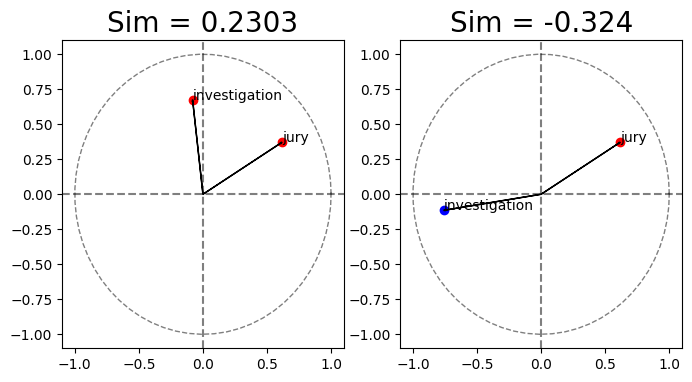

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


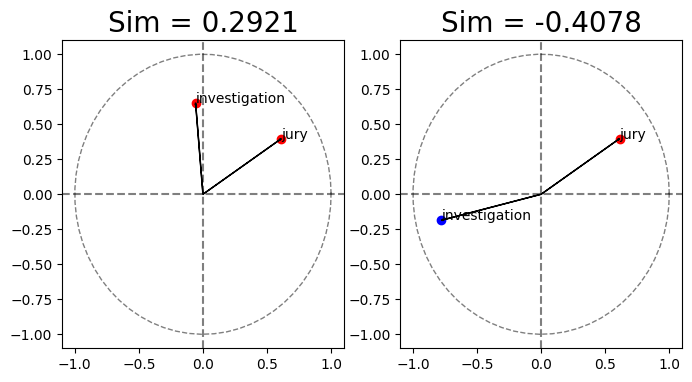

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


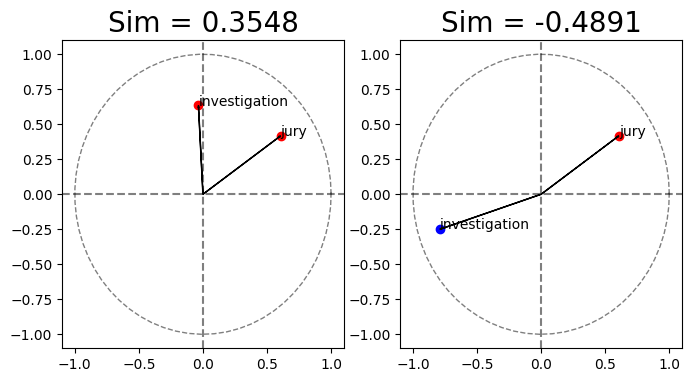

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


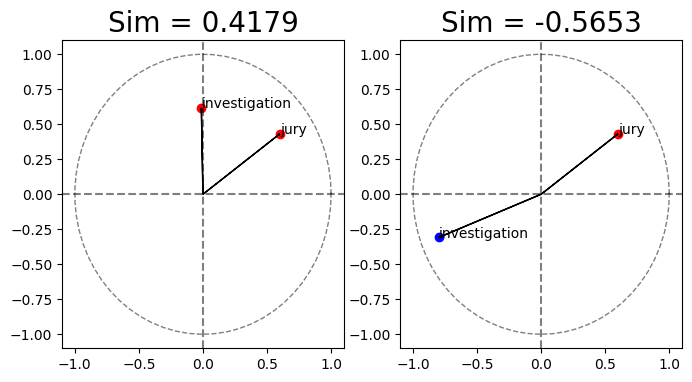

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


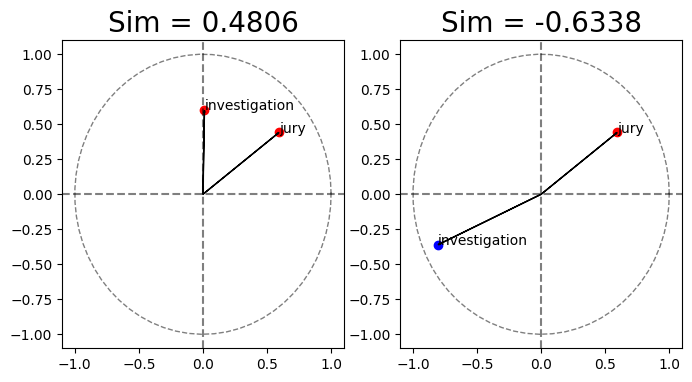

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


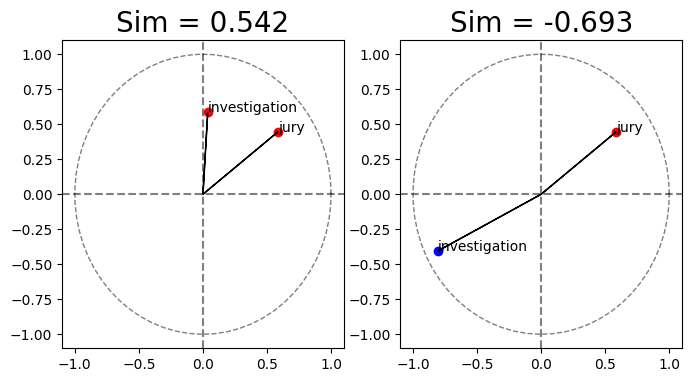

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


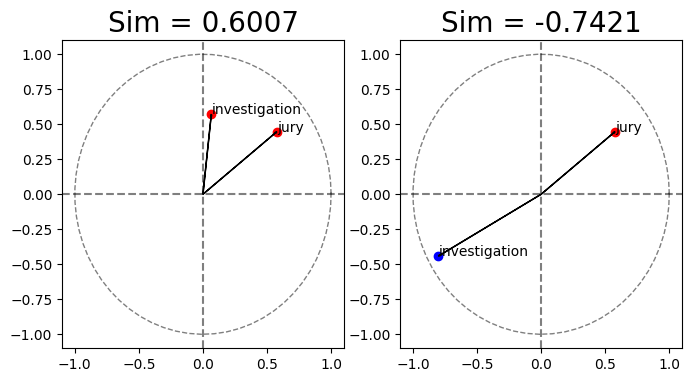

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


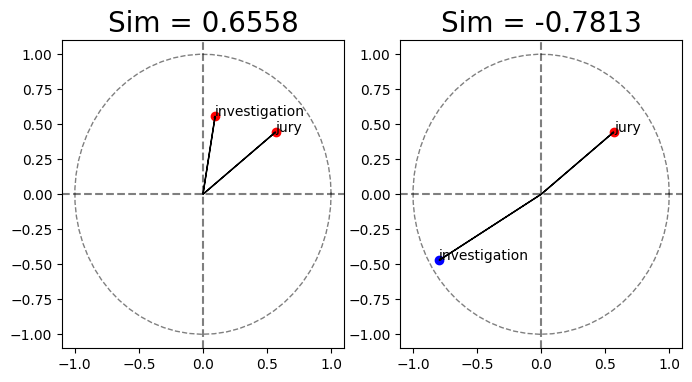

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


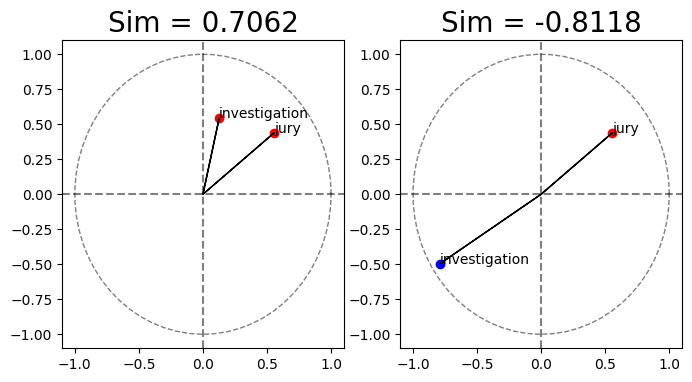

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


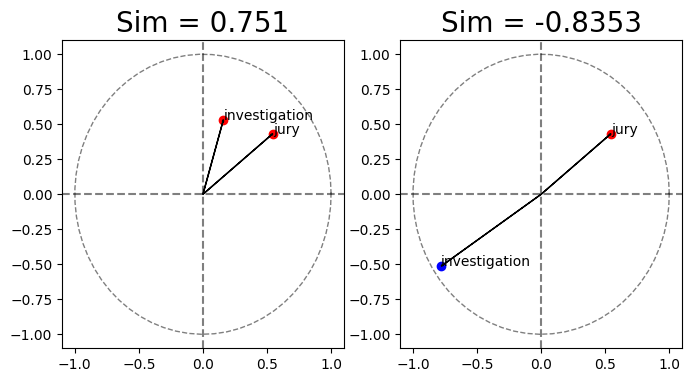

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


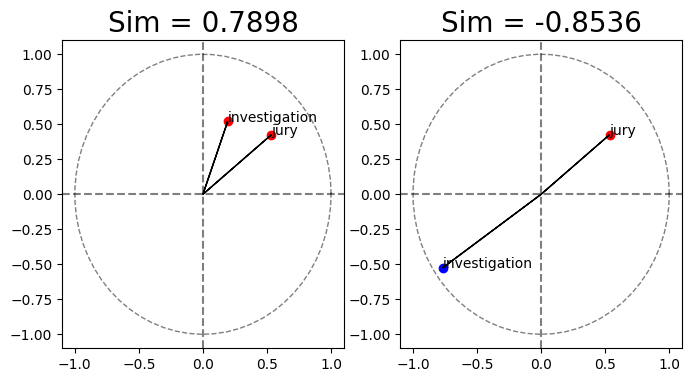

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


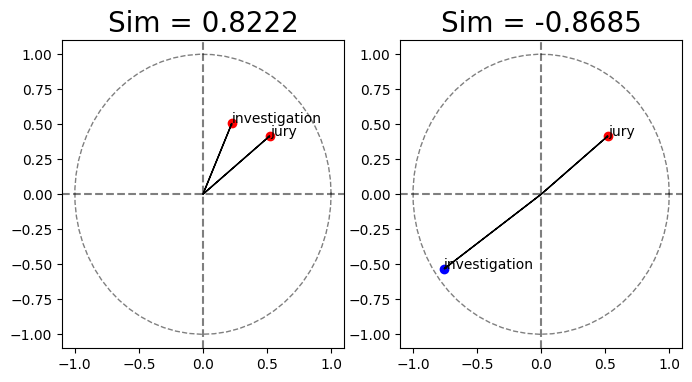

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


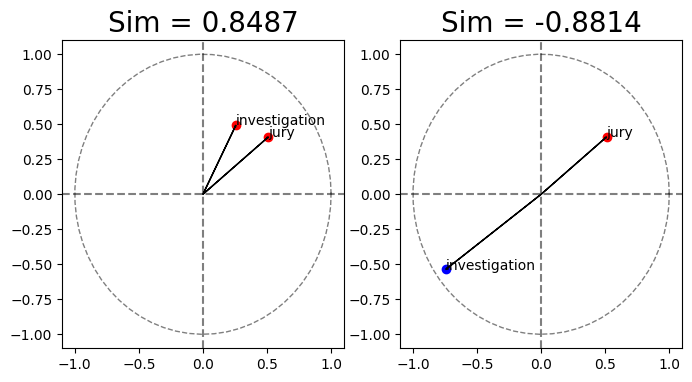

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


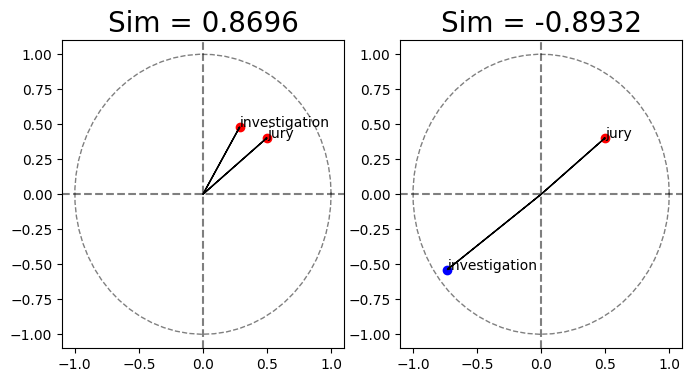

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


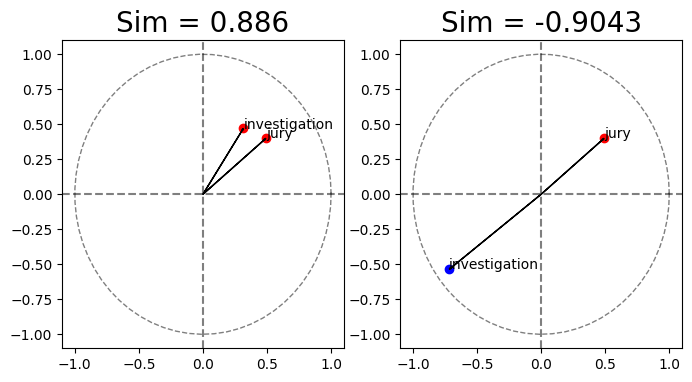

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


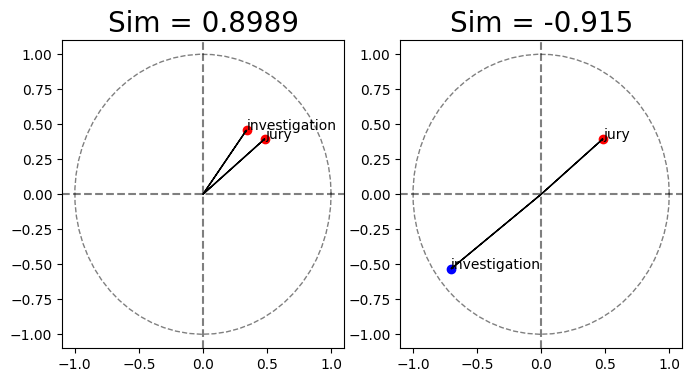

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


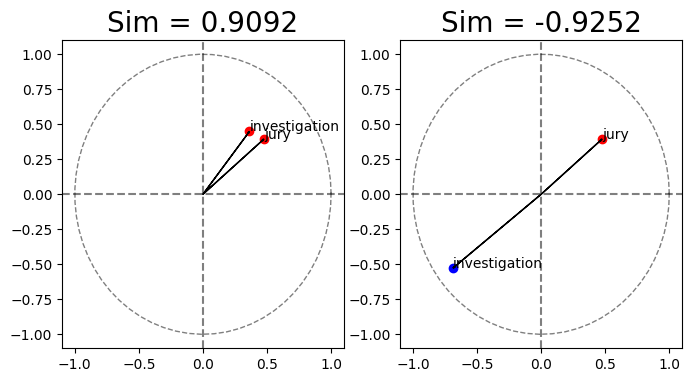

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


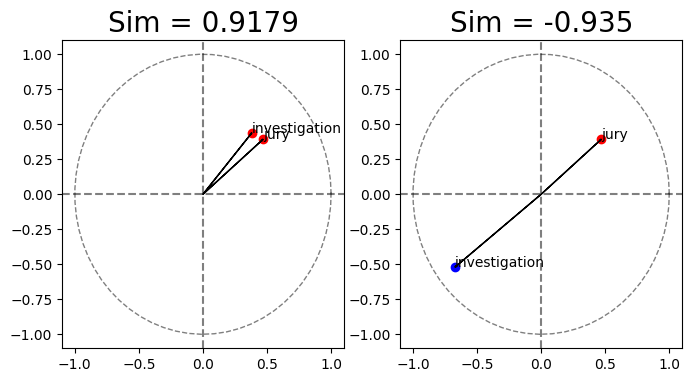

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


In [14]:
EMBEDDING_SIZE = 5

main_embeddings = np.random.normal(0, 0.1, (len(words), EMBEDDING_SIZE ))
row_norms = np.sqrt(main_embeddings**2).sum(axis = 1).reshape(-1,1)
main_embeddings = main_embeddings/row_norms



context_embeddings = np.random.normal(0, 0.1, (len(words), EMBEDDING_SIZE ))
row_norms = np.sqrt(context_embeddings**2).sum(axis = 1).reshape(-1,1)
context_embeddings = context_embeddings/row_norms

main_embeddings = pd.DataFrame(data= main_embeddings, index = words)
context_embeddings = pd.DataFrame(data = context_embeddings, index = words)

for _ in range(25):
    main_embeddings, context_embeddings = update_embeddings(df, main_embeddings, context_embeddings, 0.1, ['jury', 'investigation'])


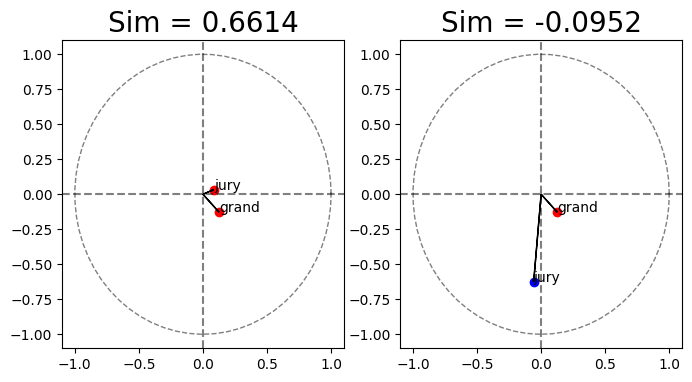

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


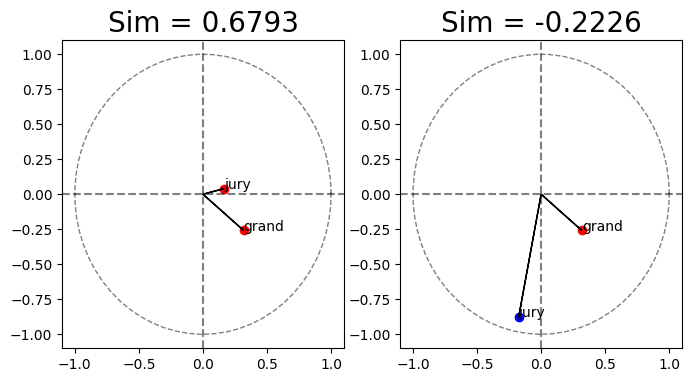

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


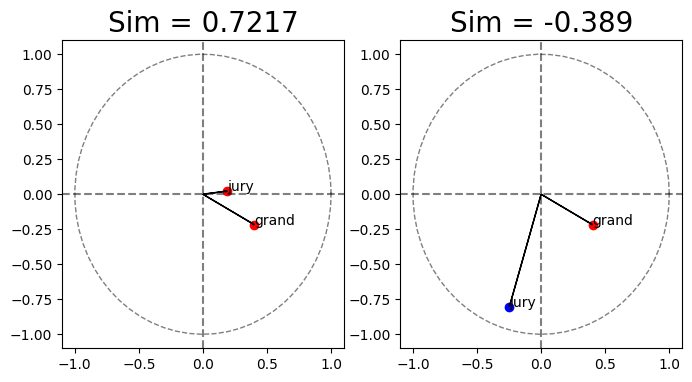

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


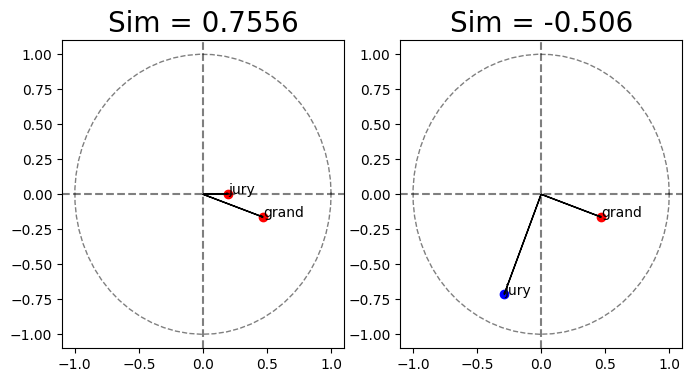

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


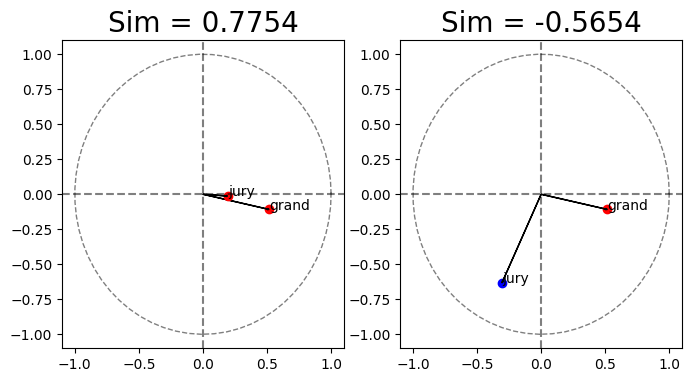

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


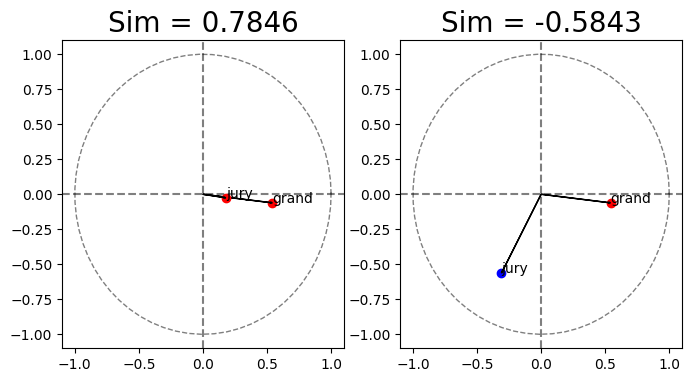

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


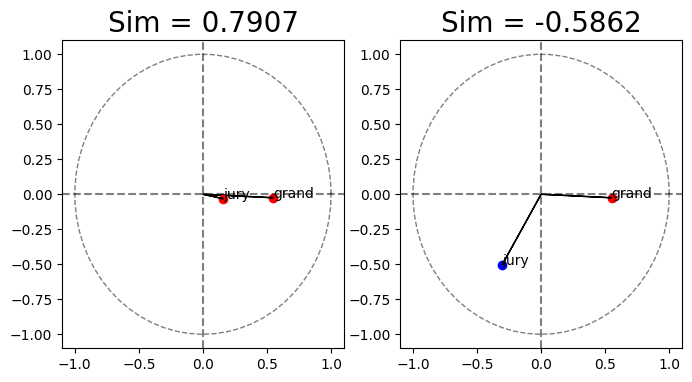

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


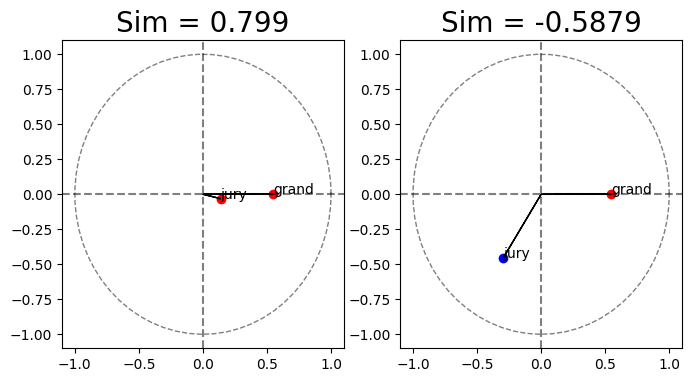

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


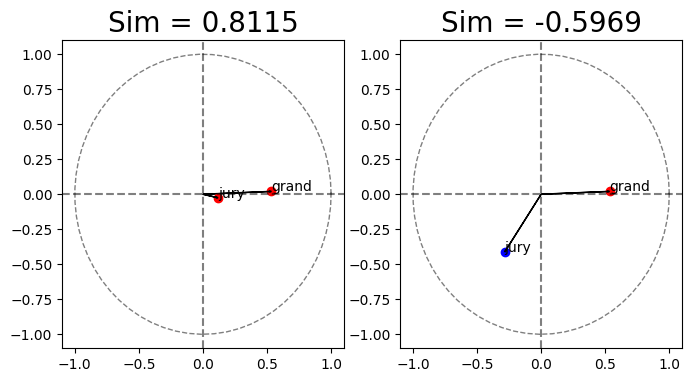

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


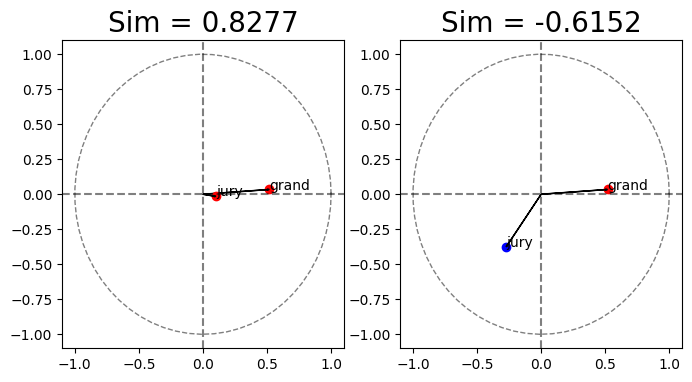

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


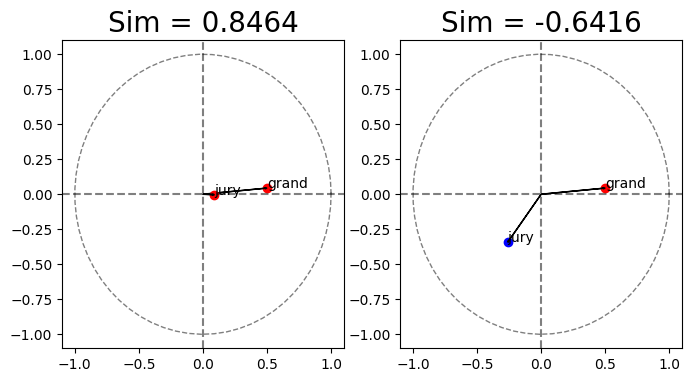

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


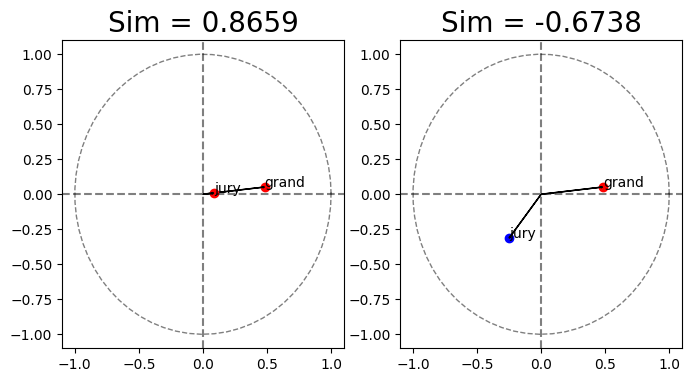

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


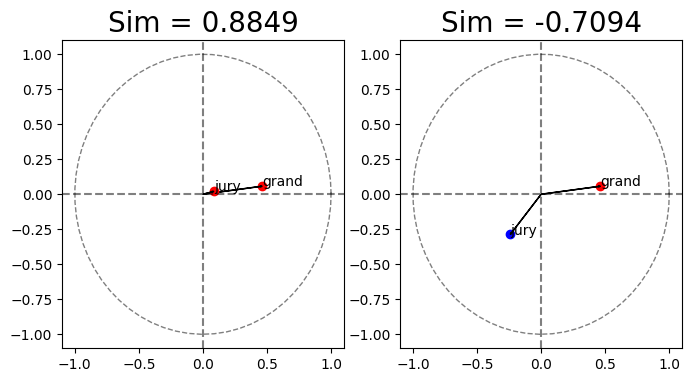

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


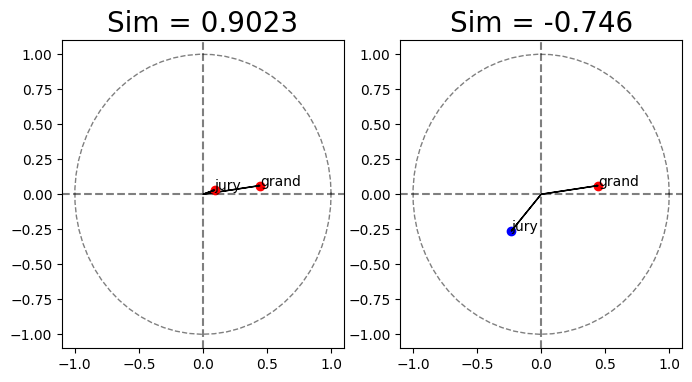

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


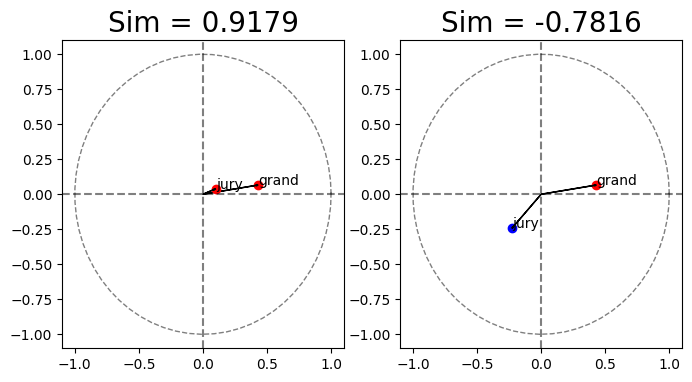

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


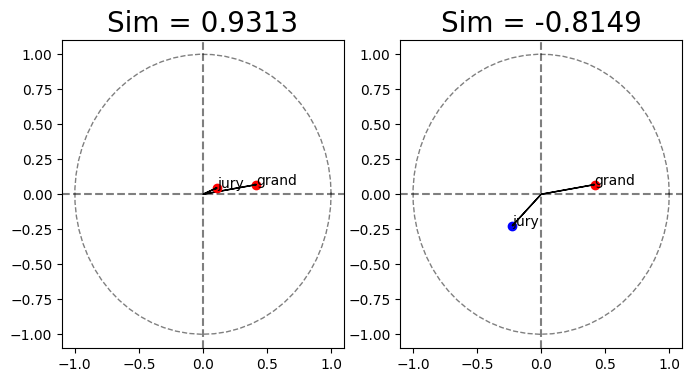

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


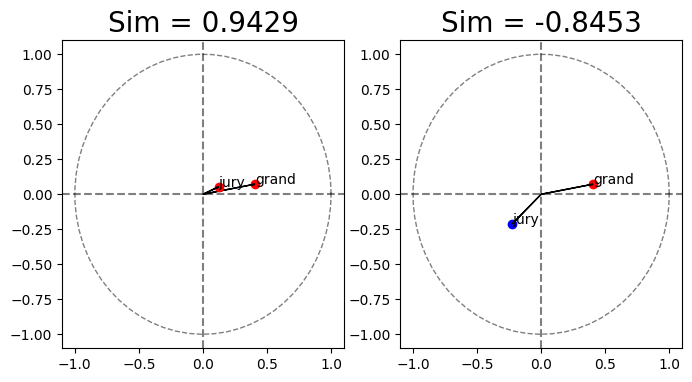

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


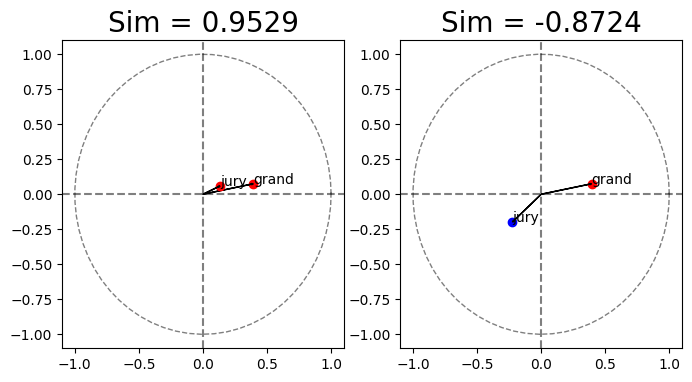

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


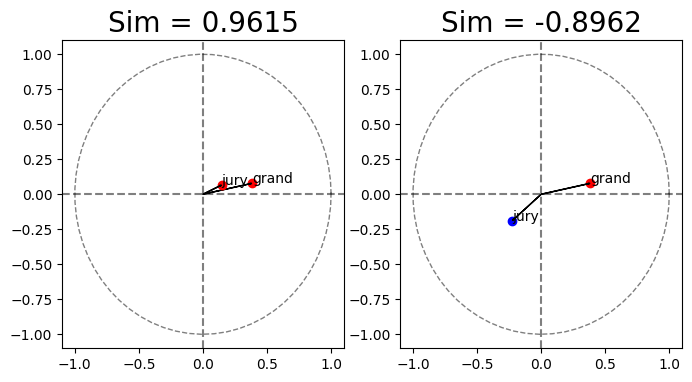

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


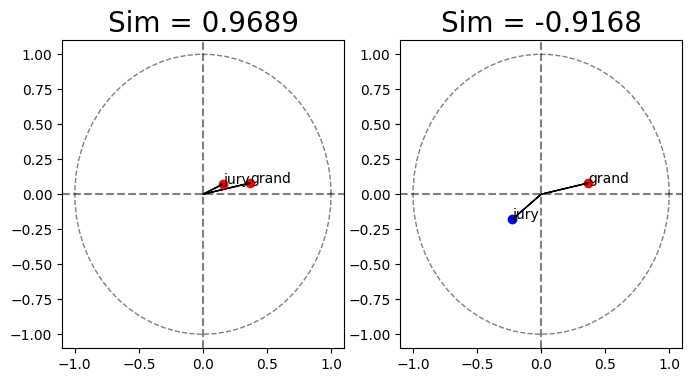

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


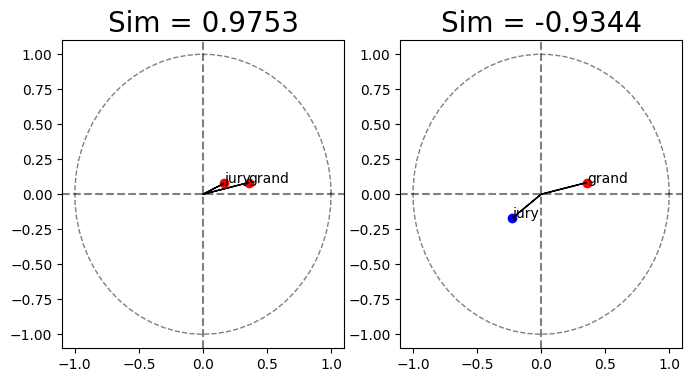

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


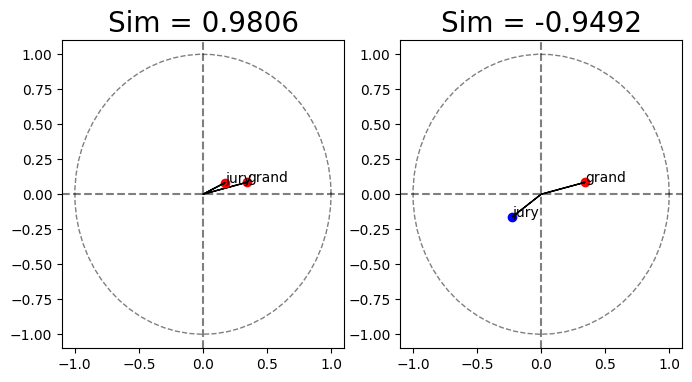

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


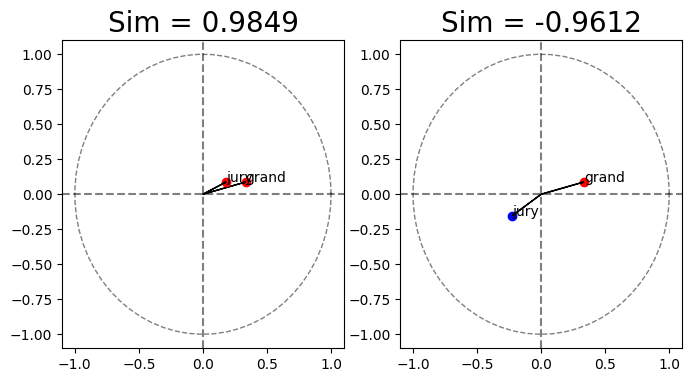

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


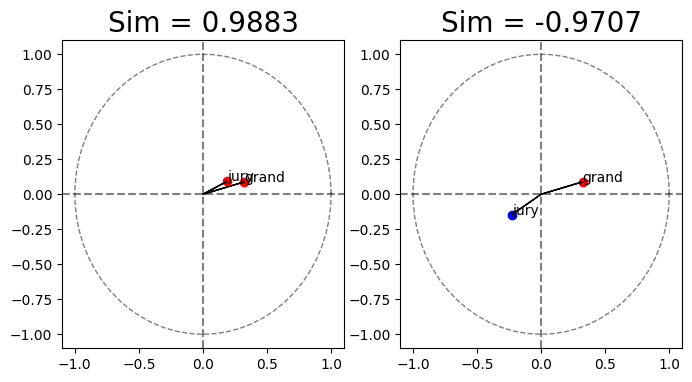

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


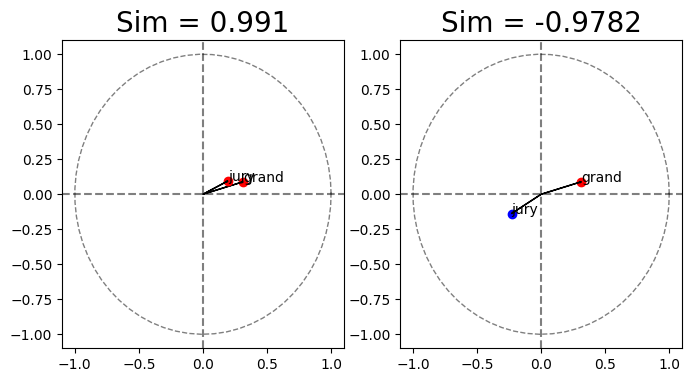

<ipython-input-11-467465ad5a67>:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_center = updates_df.groupby('center_word').sum()
<ipython-input-11-467465ad5a67>:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  updates_df_context = updates_df.groupby('context_word').sum()


In [16]:
EMBEDDING_SIZE = 5

main_embeddings = np.random.normal(0, 0.1, (len(words), EMBEDDING_SIZE ))
row_norms = np.sqrt(main_embeddings**2).sum(axis = 1).reshape(-1,1)
main_embeddings = main_embeddings/row_norms



context_embeddings = np.random.normal(0, 0.1, (len(words), EMBEDDING_SIZE ))
row_norms = np.sqrt(context_embeddings**2).sum(axis = 1).reshape(-1,1)
context_embeddings = context_embeddings/row_norms

main_embeddings = pd.DataFrame(data= main_embeddings, index = words)
context_embeddings = pd.DataFrame(data = context_embeddings, index = words)

for _ in range(25):
    main_embeddings, context_embeddings = update_embeddings(df, main_embeddings, context_embeddings, 0.1, ['grand', 'jury'])


In [17]:
L = []
for w1 in words:
    for w2 in words:
        if w1 != w2:
            sim = 1 - cosine(main_embeddings.loc[w1], main_embeddings.loc[w2])
            L.append((w1,w2,sim))
sorted([item for item in L if item[0] == 'jury'], key=lambda t: -t[2])[:10]

[('jury', 'election', 0.9988118778870099),
 ('jury', 'placethe', 0.9987355193398852),
 ('jury', 'manner', 0.9984694509061234),
 ('jury', 'investigate', 0.9977895842175222),
 ('jury', 'topics', 0.9977671547509273),
 ('jury', 'overall', 0.997747027613441),
 ('jury', 'pye', 0.9970983861375035),
 ('jury', 'studied', 0.9970640977824405),
 ('jury', 'recommended', 0.9961967688516503),
 ('jury', 'interest', 0.9953794245957833)]

# **Visualize all the Embeddings**

In [ ]:
from sklearn.decomposition import PCA

In [18]:
pca = PCA(n_components=2)
transf_embeddings = pca.fit_transform(main_embeddings.values)
words_used = main_embeddings.index

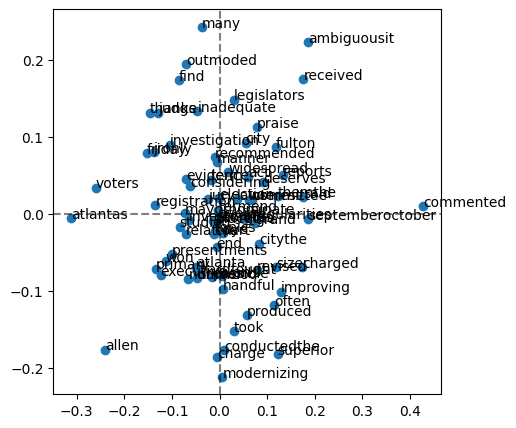

In [19]:
plt.figure(figsize=(5,5))
plt.scatter(transf_embeddings[:,0], transf_embeddings[:,1])
for idx,row in enumerate(transf_embeddings):
    plt.text(row[0], row[1], str(words_used[idx]))
plt.axvline(0, color='k', linestyle='--', alpha=0.5)
plt.axhline(0, color='k', linestyle='--', alpha=0.5)

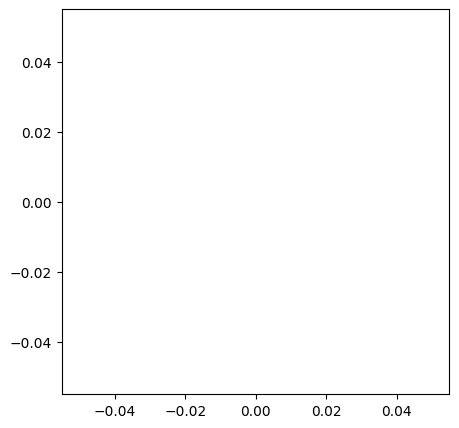

In [21]:
plt.figure(figsize=(5,5))

chosen_idxs = (transf_embeddings[:,0] < -.25) & (transf_embeddings[:,1] < -0.4)
transf_embeddings = transf_embeddings[chosen_idxs]
words_used = words_used[chosen_idxs]

plt.scatter(transf_embeddings[:,0], transf_embeddings[:,1])
for idx,row in enumerate(transf_embeddings):
    plt.text(row[0], row[1], str(words_used[idx]))